# Описание проекта.

***
**Задача:**
В проекте приведены исторические данные о заказах такси в аэропортах. Цель проекта - построить модель для прогнозирования количества заказов такси на следующий час, чтобы привлекать больше водителей в период пиковой нагрузки.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Примечание:**
Для предсказания данны 10% от данных. Считается, что для каждой записи в тестовых данных информация известна исходя из условия задачи. 
***
**Шаги проекта**

    1. Загрузка данных и ресемплирование
- Загркзка данных из файла /datasets/taxi.csv.
- Ресемплирование данных по одному часу.

    2. Анализ данных
- Анализ основных статистик данных.
- Изучение временного ряда заказов такси.

    3. Обучение моделей
- Разделение данных на обучающую и тестовую выборки.
- Обучение различных моделей с различными гиперпараметрами.
- Использование тестовой выборки размером 10% от исходных данных.

    4. Проверка и выводы
- Проверка модели на тестовой выборке.
- Оценка качества модели с использованием метрики RMSE.
- Выводы и предложения по оптимизации привлечения водителей в периоды пиковой нагрузки.


# Импорт данных.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

import catboost as cb
import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit

#pip install etna[all]
from etna.datasets import TSDataset
from etna.models import CatBoostMultiSegmentModel
from etna.transforms import DateFlagsTransform
from etna.transforms import DensityOutliersTransform
from etna.transforms import FourierTransform
from etna.transforms import LagTransform
from etna.transforms import LinearTrendTransform
from etna.transforms import MeanTransform
from etna.transforms import SegmentEncoderTransform
from etna.transforms import TimeSeriesImputerTransform
from etna.transforms import TrendTransform
from etna.pipeline import Pipeline
from etna.analysis import plot_forecast
from etna.metrics.metrics import RMSE

import warnings

# Игнорировать все предупреждения
warnings.filterwarnings("ignore")


/Users/maksimgorskov/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/Users/maksimgorskov/opt/anaconda3/lib/python3.9/site-packages/etna/settings.py:37: UserWarning: etna[torch] is not available, to install it, run `pip install etna[torch]`
  warnings.warn("etna[torch] is not available, to install it, run `pip install etna[torch]`")
/Users/maksimgorskov/opt/anaconda3/lib/python3.9/site-packages/etna/settings.py:45: UserWarning: wandb is not available, to install it, run `pip install etna[wandb]`
  warnings.warn("wandb is not available, to install it, run `pip install etna[wandb]`")
/Users/maksimgorskov/opt/anaconda3/lib/python3.9/site-packages/etna/settings.py:62: UserWarning: etna[classification] is not available, to install it, run `pip install etna[classification]`
  warnings.warn("

In [2]:
file_path_local = './taxi.csv'
file_path_hab = '/datasets/taxi.csv'
try:
    data_orders = pd.read_csv(file_path_local, parse_dates=[0])

except:
    data_orders = pd.read_csv(file_path_hab, parse_dates=[0])

In [3]:
#Копирование датафрейма для использования в модели на базе библиотеки Ethna.
data_orders_ethna = data_orders.copy()

#Замена индексов на временные значения.
data_orders = data_orders.set_index('datetime')


In [4]:
data_orders.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


**Общее описание данных:**
1) Датасет представляет собой датафрейм из двух признаков. Дата и время заказа - первый признак. Количество заказов в это время - второй.
2) Пропуски в данных отсутствуют.

# Рассемплирование.

In [5]:
#Сортировка индексов по возрастанию.
data_orders.sort_index(inplace = True)

In [6]:
#Данные семплируются с разбивкой в 1 час. Причем используется сумма всех заказов за этот час.
data_orders = data_orders.resample('1H').sum()

In [7]:
data_orders.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
#Датасет для анализа на тренд и сезонность
data = data_orders.copy()

# Анализ данных.

## Общий анализ.

Построение графика заказов на всех данных. Для общего понимания тренда отображается скользящее среднее для суток.

In [9]:
data_orders['rolling_mean'] = data_orders.rolling(24).mean()

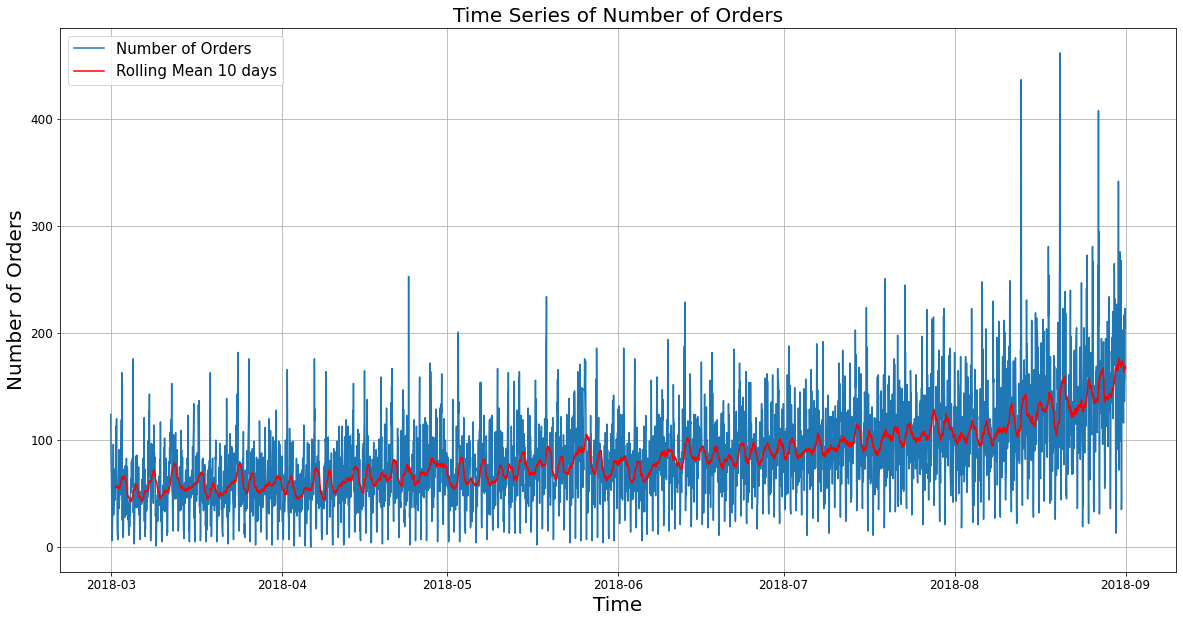

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(data_orders.index, data_orders['num_orders'], label='Number of Orders')
plt.plot(data_orders.index, data_orders['rolling_mean'], label='Rolling Mean 10 days', color='red')
plt.title('Time Series of Number of Orders', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.ylabel('Number of Orders', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

Из графика следует, что количество заказов возрастает от марта к сентябрю. Ниже представлен ежемесячный график. 

In [11]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact



def plot_with_rolling_mean(month):
    plt.figure(figsize=(15, 10))
    # Фильтраия по выбранному месяцу
    selected_month_data = data_orders[data_orders.index.month == month]

    #Вывод графика заказов
    plt.plot(selected_month_data.index, selected_month_data['num_orders'], label='Number of Orders', alpha=0.5)

    #Скользящее среднее для 7 дней
    rolling_mean = selected_month_data['num_orders'].rolling(window=7).mean()
    plt.plot(selected_month_data.index, rolling_mean, label='7-Day Rolling Mean', color='red')

    plt.title(f'Time Series of Number of Orders with 7-Day Rolling Mean for Month {month}', fontsize=16)
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Number of Orders', fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True)

    #Размерность шрифтов
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    plt.show()

#Создание интерактивного виджета для детального рассмотрения каждого месяца.
interact(plot_with_rolling_mean, month=widgets.IntSlider(min=3, max=8, step=1, value=1))

interactive(children=(IntSlider(value=3, description='month', max=8, min=3), Output()), _dom_classes=('widget-…

<function __main__.plot_with_rolling_mean(month)>

Из ежемесячного графика видно, что кол-во заказов имеет определенную цикличность исходя из скользящего среднего.

**Гипотеза:** Сезонность связана с днями недели.
    
Детально повторяющийся паттерн будет рассмотрен в следующем разделе.

## Анализ тренда и сезонности.

In [12]:
#замена первых 24 пропусков на значение 25-е по порядку в признаке rolling_mean
data_orders_11 = data_orders['rolling_mean'][25]
data_orders = data_orders.fillna(data_orders_11)

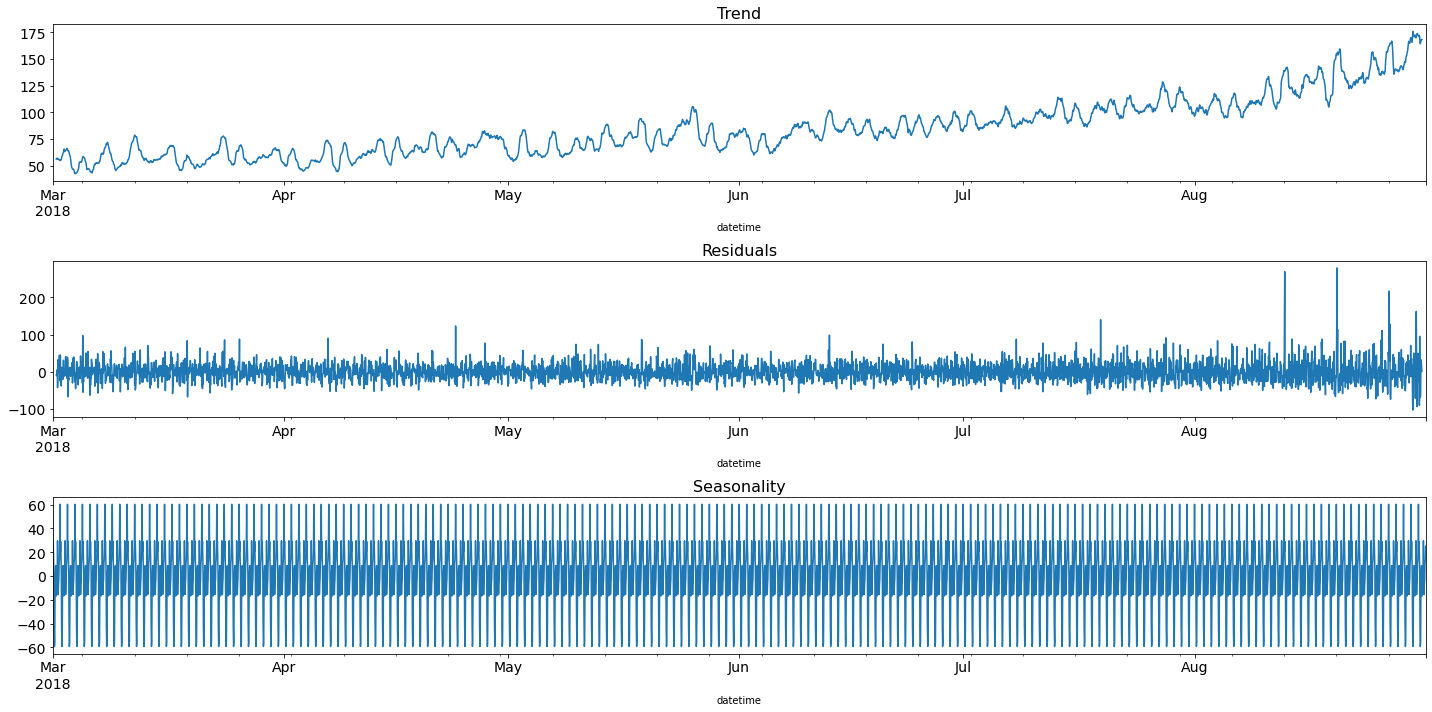

In [13]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(20, 10))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend', fontsize=16)
#Размерность шрифтов
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(312)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals', fontsize=16)
#Размерность шрифтов
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplot(313)
decomposed.seasonal.plot(ax=plt.gca()) 
# < напишите код здесь >
plt.title('Seasonality', fontsize=16)
#Размерность шрифтов
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()


### Исследование недельной сезонности.

Исходя из графика сезонности за весь промежуток времени видно, что сезонность в рамках каждого месяца описывается одни и тем же графиком. Поэтому для анализа недельной сезонности достаточно взять любую неделю из лбого месяца. 

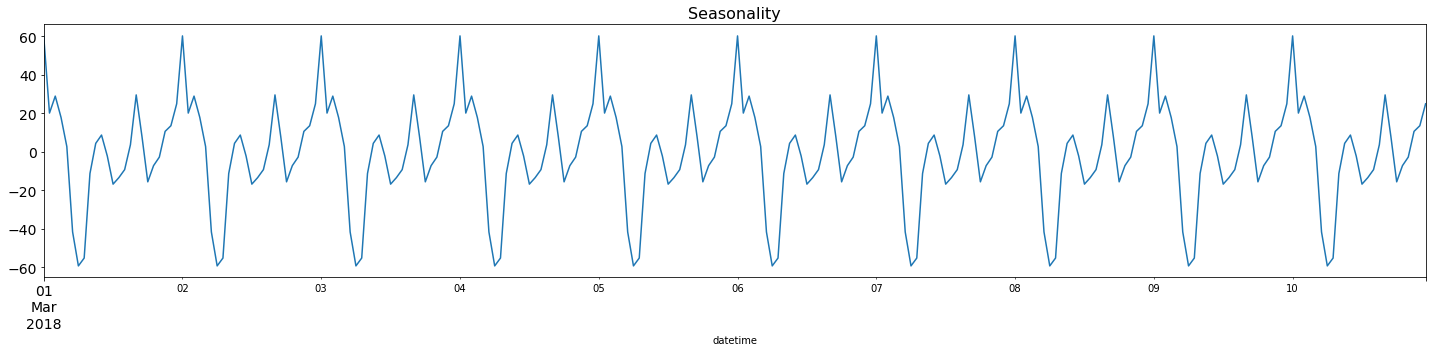

In [14]:
decomposed = seasonal_decompose(data)

# Select the seasonal component for the firs week of march
plt.figure(figsize=(20, 5))
seasonal_component_january = decomposed.seasonal['2018-03-01':'2018-03-10'].plot()
plt.title('Seasonality', fontsize=16)
#Размерность шрифтов
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()


**Из недельного графика видно, что данные имеют выраженну суточную сезонность.**

### Исследование суточной сезонности.

Анализируются первые сутки недели, рассмотренной выше.

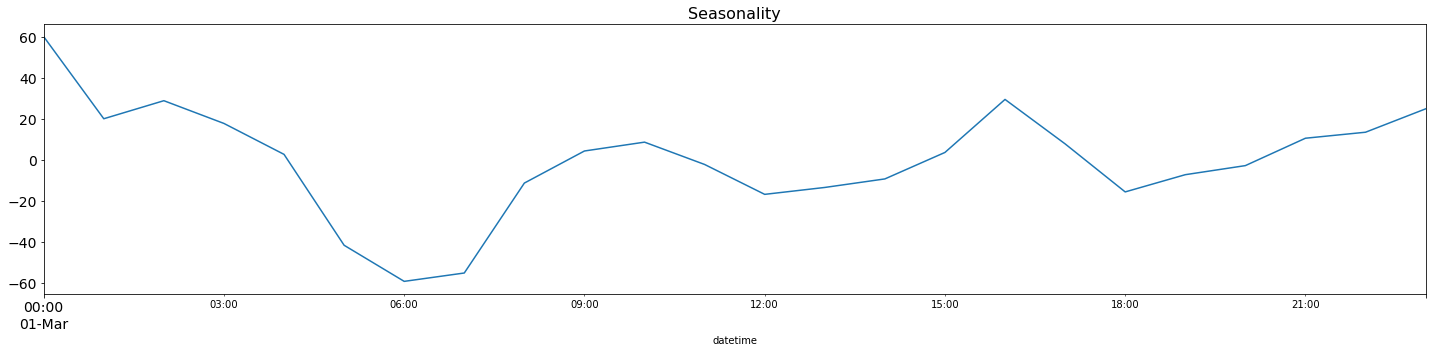

In [15]:
decomposed = seasonal_decompose(data)

# Select the seasonal component for the firs week of march
plt.figure(figsize=(20, 5))
seasonal_component_january = decomposed.seasonal['2018-03-01'].plot()
plt.title('Seasonality', fontsize=16)
#Размерность шрифтов
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()

Из графика видно, что ежесуточно пиковое количество вызовов приходится на полночь, а минимальное кол-во заказов - на 6 утра.

### Вывод.



- За весь промежуток врмени, приведенный в исходном датасете, наблюдается восходящий тренд по заказу такси. На начало сентября, количество вызовов такси выросло более чем в три раза, по сравнением с началом марта этого же года.
- Анализ на сезонность показал, что она присутствует только на уровне суток. Ежесуточно пиковое количество вызовов приходится на полночь, а минимальное кол-во заказов - на 6 утра. Какая-либо цикличность на большем масштабе времени - отсутствует.

## Формирование дополнительных признаков.

Функция для добавления скользящего среднего и отстающих значений.

In [16]:
def make_features(data, max_lag, rolling_mean_size):
    data_modify = data.copy()
    
    data_modify['month'] = data_modify.index.month
    data_modify['day'] = data_modify.index.day
    data_modify['dayofweek'] = data_modify.index.dayofweek
    data_modify['hour'] = data_modify.index.hour
    # Для учета цикличности времени, часы заменяются на синус радиана часа суток.
    data_modify['hour_sin'] = np.sin(np.radians(data_modify['hour']))
    
    for lag in range(1, max_lag + 1):
        data_modify['lag_{}'.format(lag)] = data_modify['num_orders'].shift(lag)
        #Заполнение пропусков первым значением не равным NaN
        fill_value = data_modify['lag_{}'.format(lag)].first_valid_index()
        first_non_nan_value = data_modify['lag_{}'.format(lag)].loc[fill_value]
        data_modify['lag_{}'.format(lag)] = data_modify['lag_{}'.format(lag)].fillna(first_non_nan_value)

    data_modify['rolling_mean'] = data_modify['num_orders'].shift().rolling(rolling_mean_size).mean()
    #Заполнение пропусков первым значением не равным NaN
    fill_value = data_modify['rolling_mean'].first_valid_index()
    first_non_nan_value = data_modify['rolling_mean'].loc[fill_value]
    data_modify['rolling_mean'] = data_modify['rolling_mean'].fillna(first_non_nan_value)
    
    return data_modify


data_modify = make_features(data_orders, 24, 24)

In [17]:
data_modify.head(5)

,num_orders,rolling_mean,month,day,dayofweek,hour,hour_sin,lag_1,lag_2,lag_3,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,56.833333,3,1,3,0,0.000000,124.0,124.0,124.0,...,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0
2018-03-01 01:00:00,85,56.833333,3,1,3,1,0.017452,124.0,124.0,124.0,...,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0
2018-03-01 02:00:00,71,56.833333,3,1,3,2,0.034899,85.0,124.0,124.0,...,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0
2018-03-01 03:00:00,66,56.833333,3,1,3,3,0.052336,71.0,85.0,124.0,...,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0
2018-03-01 04:00:00,43,56.833333,3,1,3,4,0.069756,66.0,71.0,85.0,...,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0,124.0


# Модель для прогнозирования количества заказов

## Определение тестовой и валидационной выборки.

Разбиение на тестовую и валидационную выборку.

In [18]:
y = data_modify['num_orders']
X = data_modify.drop('num_orders', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1)

## Инициализация сравнительной таблицы.

Для анализа качества моделей и выбора наилучшей из них - формируется сводная таблица с результатами работ каждой из них.

In [19]:
df = {'ML model' : [],
              'RMSE' : []}
comparing = pd.DataFrame(df)
comparing

,ML model,RMSE


## Cat Boost

In [20]:
#Инициализация модели CatBoostRegressor.
rndm = 12345
model_cbr = cb.CatBoostRegressor(random_seed=rndm,
                                boosting_type='Ordered')

In [21]:
param_grid = {
    'iterations': range(100, 2000, 500),
    'depth': range(1, 6, 2),
    'learning_rate': [0.01, 0.1, 0.02]
}

In [22]:
# Create GridSearchCV object
tscv = TimeSeriesSplit(n_splits=10) #Кроссвалидация для временного ряда.
grid_search = GridSearchCV(estimator=model_cbr,
                           param_grid=param_grid,
                           cv = tscv,
                           scoring='neg_mean_squared_error',
                           verbose=False #отключение вывода прогресса обучения
                          )  
grid_search.fit(X_train, y_train, verbose=False)


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7fd210a18af0>,
             param_grid={'depth': range(1, 6, 2),
                         'iterations': range(100, 2000, 500),
                         'learning_rate': [0.01, 0.1, 0.02]},
             scoring='neg_mean_squared_error', verbose=False)

In [23]:
# Получение лучших параметров и модели
best_params = grid_search.best_params_
print(f'Лучшие гиперпараметры: {best_params}')
best_model = grid_search.best_estimator_

Лучшие гиперпараметры: {'depth': 5, 'iterations': 1600, 'learning_rate': 0.02}


In [24]:
#Предикт на тестовой выборке.
predictions = best_model.predict(X_test)

In [25]:
#Вычисление среднеквадратичной ошибки (MSE)
mse = mean_squared_error(y_test, predictions)

In [26]:
#Вычисление корня из среднеквадратичной ошибкиошибки (RMSE)
rmse = rmse = np.sqrt(mse)
print(f'Метрика rmse: {rmse}')

Метрика rmse: 42.07752215719716


In [27]:
# Создание словаря с новой строкой
df_append = {'ML model': 'CatBoost_test', 'RMSE': rmse}

# Создание нового DataFrame с одной строкой
new_row = pd.DataFrame([df_append])

# Объединение (конкатенация) существующего DataFrame с новым DataFrame
comparing = pd.concat([comparing, new_row], ignore_index=True)
comparing


,ML model,RMSE
0,CatBoost_test,42.077522


## LightGBM

In [28]:
#Инициализация модели.
model_lgb = lgb.LGBMRegressor(random_seed=rndm)

In [29]:
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': list(range(100, 2400, 400)),
    'max_depth': list(range(1, 4, 2))
}

In [30]:
# Создание объекта GridSearchCV
tscv = TimeSeriesSplit(n_splits=10) #Кроссвалидация для временного ряда.
grid_search = GridSearchCV(estimator=model_lgb, 
                           param_grid=param_grid,
                           cv = tscv,
                           scoring='neg_mean_squared_error',
                           verbose=False #отключение вывода прогресса обучения
                          )

# Обучение на тренировочных данных
grid_search.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=10, test_size=None),
             estimator=LGBMRegressor(random_seed=12345),
             param_grid={'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [1, 3],
                         'n_estimators': [100, 500, 900, 1300, 1700, 2100]},
             scoring='neg_mean_squared_error', verbose=False)

In [31]:
# Получение лучших параметров и модели
best_params = grid_search.best_params_
print(f'Лучшие гиперпараметры: {best_params}')
best_model = grid_search.best_estimator_

Лучшие гиперпараметры: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 2100}


In [32]:
#Предикт на валидационной выборке.
predictions = best_model.predict(X_test)

In [33]:
#Вычисление среднеквадратичной ошибки (MSE)
mse = mean_squared_error(y_test, predictions)

In [34]:
#Вычисление корня из среднеквадратичной ошибкиошибки (RMSE)
rmse = rmse = np.sqrt(mse)
print(f'Метрика rmse: {rmse}')

Метрика rmse: 40.958198583502835


In [35]:
# Создание словаря с новой строкой
df_append = {'ML model': 'LightGBM_valid', 'RMSE': rmse}

# Создание нового DataFrame с одной строкой
new_row = pd.DataFrame([df_append])

# Объединение (конкатенация) существующего DataFrame с новым DataFrame
comparing = pd.concat([comparing, new_row], ignore_index=True)
comparing

,ML model,RMSE
0,CatBoost_test,42.077522
1,LightGBM_valid,40.958199


## Вывод.

Лучшей моделью является LightGBM. Метрика RMSE составляет 40,95 вызовов такси в час. Это почти на 9% лучше ожидаемой метрики.

## Предсказание временного ряда с помощью библиотеки Ethna.

**Вводное описание библиотеки Ethna.**

Библиотека Etna требовательна относительно формата данных:

- Столбец с целевым признаком должен называться "target".
- Столбец с данными о времени должен называться "timestamp".
- Поскольку Etna всегда готова работать с несколькими временными рядами, столбец "segment" также обязателен.

Исходя их этих требований ниже идет форматирование данных под стандарты библиотеки.

К плюсом библиотеки можно отнести тот факт, что ее использование исклбчает возможность утечки данных и "заглядывания" модели в будущее.

In [36]:
# Переименование столбцов в соответствии с требованиями библиотеки.
data_orders_ethna.rename(columns={'datetime': 'timestamp',
                  'num_orders' : 'target'}, inplace=True)
data_orders_ethna['segment'] = 'taxi'
data_orders_ethna

,timestamp,target,segment
0,2018-03-01 00:00:00,9,taxi
1,2018-03-01 00:10:00,14,taxi
2,2018-03-01 00:20:00,28,taxi
3,2018-03-01 00:30:00,20,taxi
4,2018-03-01 00:40:00,32,taxi
...,...,...,...
26491,2018-08-31 23:10:00,32,taxi
26492,2018-08-31 23:20:00,24,taxi
26493,2018-08-31 23:30:00,27,taxi
26494,2018-08-31 23:40:00,39,taxi


In [37]:
#Создание датасета TSDataset. Временной шаг = час.
data_orders_ethna = TSDataset.to_dataset(data_orders_ethna)
ts = TSDataset(data_orders_ethna, freq="H")

<AxesSubplot:xlabel='timestamp'>

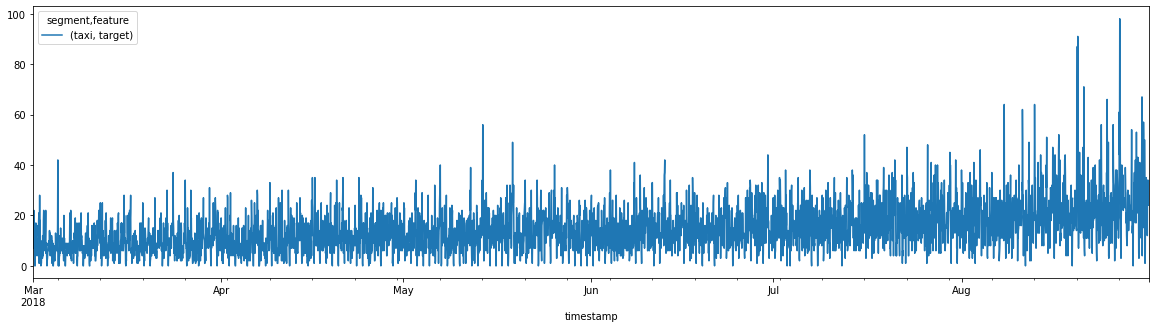

In [38]:
#Изображение времемнного ряда TSDataset на графике.
ts.to_pandas().plot(figsize=(20, 5))

В библиотеке Ethna необходимо задать горизонт прогнозирования. Исходя из условия задачи необходимо рассчитать данные для 10% от выборки. 
Исходя из этого условия ниже рассчитывается горизонт планирования. (Он же будет выступать в роли тестовой выборки).

In [39]:
HORIZON = round(4416*0.1)
HORIZON

442

In [40]:
#Разбиение на тренировочную и тестовую выборки.
train_ts, test_ts = ts.train_test_split(test_size=HORIZON)


In [41]:
#Подготовка трансформеров для пайплайна
transforms = [
    DensityOutliersTransform(in_column="target", distance_coef=3.0),
    TimeSeriesImputerTransform(in_column="target", strategy="forward_fill"),
    LinearTrendTransform(in_column="target"),
    TrendTransform(in_column="target", out_column="trend"),
    LagTransform(in_column="target", lags=list(range(HORIZON, 24)), out_column="target_lag"),
    DateFlagsTransform(week_number_in_month=True, out_column="date_flag"),
    FourierTransform(period=360.25, order=6, out_column="fourier"),
    SegmentEncoderTransform()
    #MeanTransform(in_column=f"target_lag_{HORIZON}", window=12, seasonality=7),
    #MeanTransform(in_column=f"target_lag_{HORIZON}", window=24)
]

# Prepare model
model = CatBoostMultiSegmentModel()

In [42]:
#Создание пайплайна и обучение модели.
pipeline = Pipeline(model=model, transforms=transforms, horizon=HORIZON)
pipeline.fit(train_ts)

#Формирование прогноза.
forecast_ts = pipeline.forecast()

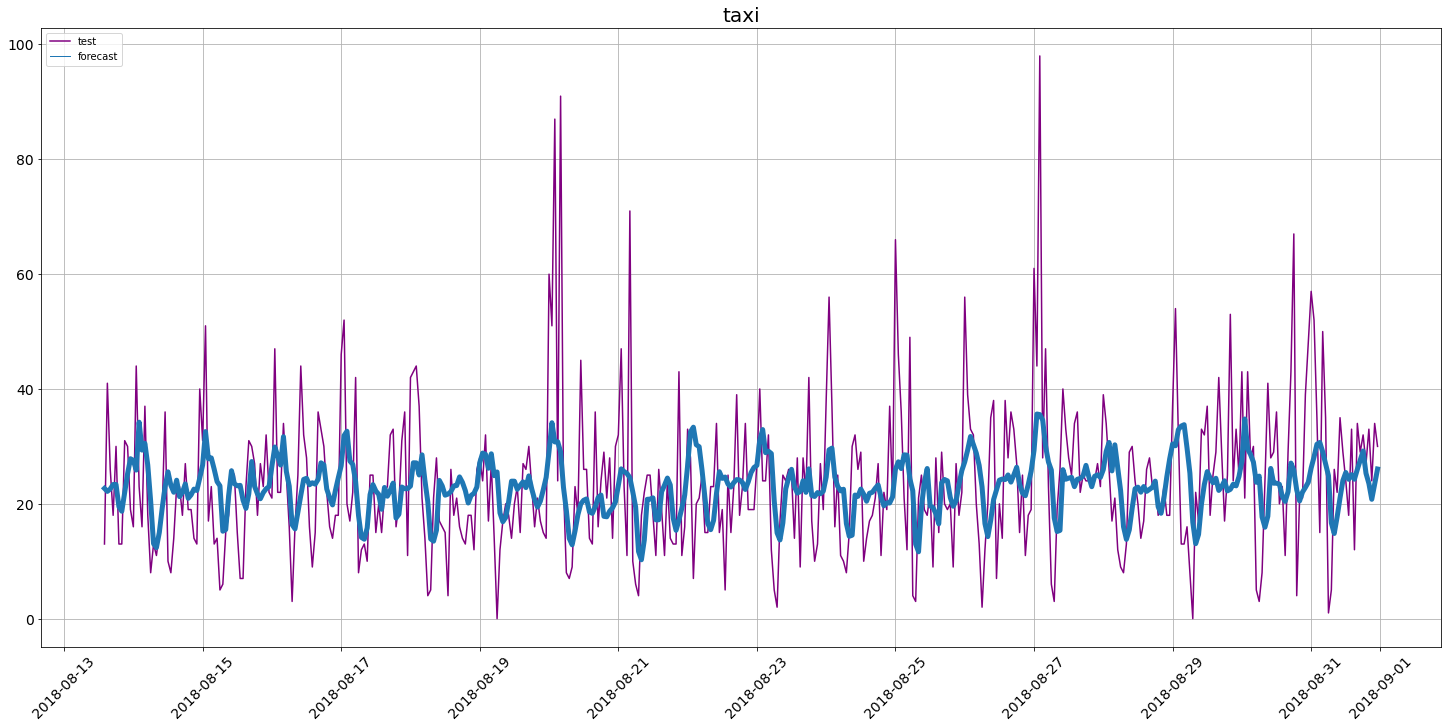

In [43]:
#Вывод на печать прогноза и фактических данных для их визуального коррелирования.
plot_forecast(forecast_ts=forecast_ts, 
              test_ts=test_ts, 
              train_ts=train_ts, 
              n_train_samples=0, 
              figsize=(20, 10))

# Получение текущей фигуры
fig = plt.gcf()

# Получение оси текущей фигуры
axes = fig.get_axes()
# Получение линии графика
lines = axes[0].lines
#Изменение толщины линии тестовых данных

lines[1].set_linewidth(5)

plt.title('taxi', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("/Users/maksimgorskov/Desktop/Data Science/Спринт 19_Временные ряды/Проектная работа/Предсказание_Факт.png")
plt.show()


**Анализ графика:**
- Из графика видно, что предсказанные значения повторяют общие локальные тренды фактических значений временного ряда. Однако видны значительные отклонения между предсказанными данными и фактическими, в точках максимальной валатильности графика, построенного на тестовой выборке.
- Эти пики и дают бОльший вклад в ухудшение метрики. Средние значения модель определяет достаточно точно.

In [44]:
metric = RMSE()
metric_value = metric(y_true = test_ts, y_pred = forecast_ts)
metric_value = metric_value['taxi'].round()
print(f'Метрика RMSE = {metric_value}')

Метрика RMSE = 12.0


In [45]:
# Создание словаря с новой строкой
df_append = {'ML model': 'Ethna', 'RMSE': metric_value}

# Создание нового DataFrame с одной строкой
new_row = pd.DataFrame([df_append])

# Объединение (конкатенация) существующего DataFrame с новым DataFrame
comparing = pd.concat([comparing, new_row], ignore_index=True)
comparing

,ML model,RMSE
0,CatBoost_test,42.077522
1,LightGBM_valid,40.958199
2,Ethna,12.000000


Применение библиотеки Ethna является наиболее эффективным способом рассчета потребности такси на следующий час работы сервиса. 
Метрика RMSE в данной методологии достигаел 12 шт. что на 75% лучше требуемой метрики.

# Вывод.

**Итоги по основным вехам проекта:**

    1. Анализ данных
- За весь промежуток врмени, приведенный в исходном датасете, наблюдается восходящий тренд по заказу такси. На начало сентября, количество вызовов такси выросло более чем в три раза, по сравнением с началом марта этого же года.
- Анализ на сезонность показал, что она присутствует только на уровне суток. Ежесуточно пиковое количество вызовов приходится на полночь, а минимальное кол-во заказов - на 6 утра.
    2. Обучение моделей
- На тренировочной выборке были обучены модели CatBoost и LightGBM. Тестирование показало, что наиболее оптимально использовать модель LightGBM. У моделей получились схожие метрики RMSE: 42,07 - CatBoost, и 40,9- LightGBM. 
- Для сравнения результатов с стандартными моделями ML была применена библиотека **Ethna**, которая является специализированным инструментом для работы с временными рядами. Значение метрики RMSE на тестовой выборке составило 12 ед.

**Результат:**

Применение библиотеки Ethna является наиболее эффективным способом рассчета потребности такси на следующий час работы сервиса. 
Метрика RMSE в данной методологии достигаел 12 шт., что на 75% лучше требуемой метрики.